# Referense

https://mizchi.hatenablog.com/entry/2019/02/08/183056

# Libraries

In [1]:
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Input dataset

In [2]:
train = pd.read_csv('../input/train.csv')

# Data preparation

In [3]:
def missing_value_table(df):
  #欠損値がそのカラムにいくつあるかを出力する
  null_val = df.isnull().sum()
  #それぞれのカラムで欠損値がどのくらいの割合を占めているかを計算する
  percent = 100 * df.isnull().sum()/len(df)
  #pandasのconcatメソッドで欠損数とその割合をaxis=1方向に連結する
  missing_table = pd.concat([null_val, percent], axis=1)
  #pandas.DataFrameの行名・列名を変更する
  missing_table_ren_columns = missing_table.rename(
  columns = {0 : '欠損数', 1 : '%'})
  return missing_table_ren_columns

In [4]:
missing_value_table(train)

,欠損数,%
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,177,19.865320
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


In [5]:
def data_filter(data):
    not_concerned_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']
#     not_concerned_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'Age']
    data = data.drop(not_concerned_columns, axis=1)
    data = data.dropna()
    return data

In [6]:
train = data_filter(train)

In [7]:
missing_value_table(train)

,欠損数,%
Survived,0,0.0
Pclass,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Fare,0,0.0
Embarked,0,0.0


# Normalize

In [8]:
def normalize_data(data):
    # normalize Label:Sex to int
    le = LabelEncoder()
    le.fit(['male', 'female'])
    data['Sex'] = le.transform(data['Sex'])

    # normalize Pclass
    dummy_columns = ['Pclass']
    for column in dummy_columns:
        data = pd.concat([data, pd.get_dummies(
            data[column], prefix=column)], axis=1)
        data = data.drop(column, axis=1)

    # normalize Embarked
    dummy_columns = ['Embarked']
    for column in dummy_columns:
        data = pd.concat([data, pd.get_dummies(
            data[column], prefix=column)], axis=1)
        data = data.drop(column, axis=1)

    # normalize Age
    ss = StandardScaler()
    data['Age'] = ss.fit_transform(data['Age'].values.reshape(-1, 1))

    # normalize Age
    ss = StandardScaler()
    data['Fare'] = ss.fit_transform(data['Fare'].values.reshape(-1, 1))

    return data

In [9]:
normalized_data = normalize_data(train)

In [10]:
normalized_data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,-0.527669,1,0,-0.516380,0,0,1,0,0,1
1,1,0,0.577094,1,0,0.694046,1,0,0,1,0,0
2,1,0,-0.251478,0,0,-0.503620,0,0,1,0,0,1
3,1,0,0.369951,1,0,0.350326,1,0,0,0,0,1
4,0,1,0.369951,0,0,-0.501257,0,0,1,0,0,1


# Split

In [11]:
def split_train_and_test(data, rate=0.8):
    data_y = data['Survived']
    data_x = data.drop(['Survived'], axis=1)

    train_valid_split_idx = int(len(data_x) * rate)
    train_x = data_x[:train_valid_split_idx]
    train_y = data_y[:train_valid_split_idx]

    valid_test_split_idx = (len(data_x) - train_valid_split_idx) // 2
    test_x = data_x[train_valid_split_idx + valid_test_split_idx:]
    test_y = data_y[train_valid_split_idx + valid_test_split_idx:]

    return train_x.values, train_y.values.reshape(-1, 1), test_x.values, test_y.values.reshape(-1, 1)

In [12]:
train_x, train_y, test_x, test_y = split_train_and_test(normalized_data, 0.8)

# Model

In [13]:
def build_model(input_dim):
#     model = Sequential()
#     model.add(Dense(20, input_dim=input_dim))
#     model.add(Activation('relu'))
#     model.add(Dense(1, input_dim=20))
#     model.add(Activation('sigmoid'))
#     model.compile(optimizer=SGD(lr=0.01),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

#     model = Sequential()
#     model.add(Dense(20, input_dim=input_dim))
#     model.add(Activation('relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(1, input_dim=20))
#     model.add(Activation('sigmoid'))
# #     model.compile(optimizer=SGD(lr=0.0001),
#     model.compile(optimizer=SGD(lr=0.01),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

    # create model
    model = Sequential()
#     model.add(Dense(64, input_shape=(8,)))
    model.add(Dense(64, input_dim=train_x.shape[1]))

    for i in range(0, 8):
        model.add(Dense(units=64))
        model.add(Activation('relu'))

    model.add(Dense(units=1))
    model.add(Activation('linear'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])

    return model

In [14]:
train_x.shape[1]

11

In [15]:
model = build_model(train_x.shape[1])

Instructions for updating:
Colocations handled automatically by placer.


# Train

In [16]:
history = model.fit(train_x, train_y, nb_epoch=120, batch_size=32, verbose=1)

Instructions for updating:
Use tf.cast instead.


/home/reyes/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/120
569/569 [==============================] - 1s 2ms/step - loss: 0.2348 - acc: 0.6415
Epoch 2/120
569/569 [==============================] - 0s 79us/step - loss: 0.1593 - acc: 0.7944
Epoch 3/120
569/569 [==============================] - 0s 79us/step - loss: 0.1474 - acc: 0.8067
Epoch 4/120
569/569 [==============================] - 0s 83us/step - loss: 0.1378 - acc: 0.8084
Epoch 5/120
569/569 [==============================] - 0s 104us/step - loss: 0.1366 - acc: 0.8172
Epoch 6/120
569/569 [==============================] - 0s 109us/step - loss: 0.1332 - acc: 0.8348
Epoch 7/120
569/569 [==============================] - 0s 105us/step - loss: 0.1325 - acc: 0.8243
Epoch 8/120
569/569 [==============================] - 0s 106us/step - loss: 0.1284 - acc: 0.8207
Epoch 9/120
569/569 [==============================] - 0s 105us/step - loss: 0.1281 - acc: 0.8155
Epoch 10/120
569/569 [==============================] - 0s 105us/step - loss: 0.1253 - acc: 0.8489
Epoch 11/120
569/569 [==

Epoch 84/120
569/569 [==============================] - 0s 129us/step - loss: 0.0851 - acc: 0.8875
Epoch 85/120
569/569 [==============================] - 0s 129us/step - loss: 0.0861 - acc: 0.8822
Epoch 86/120
569/569 [==============================] - 0s 155us/step - loss: 0.0814 - acc: 0.8893
Epoch 87/120
569/569 [==============================] - 0s 161us/step - loss: 0.0821 - acc: 0.8946
Epoch 88/120
569/569 [==============================] - 0s 184us/step - loss: 0.0787 - acc: 0.8998
Epoch 89/120
569/569 [==============================] - 0s 187us/step - loss: 0.0829 - acc: 0.8875
Epoch 90/120
569/569 [==============================] - 0s 189us/step - loss: 0.0926 - acc: 0.8805
Epoch 91/120
569/569 [==============================] - 0s 190us/step - loss: 0.0852 - acc: 0.8875
Epoch 92/120
569/569 [==============================] - 0s 195us/step - loss: 0.0795 - acc: 0.8928
Epoch 93/120
569/569 [==============================] - 0s 188us/step - loss: 0.0803 - acc: 0.8963
Epoch 94/1

In [17]:
history.history.keys()

dict_keys(['acc', 'loss'])

In [18]:
max(history.history['acc'])

0.9068541291099441

In [19]:
min(history.history['loss'])

0.0729734564105111

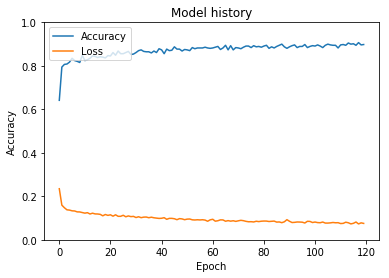

In [20]:
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('Model history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.ylim(0.0, 1.0)
plt.show()

# Test

In [21]:
[loss, accuracy] = model.evaluate(test_x, test_y)
print('loss:{0} -- accuracy:{1}'.format(loss, accuracy))

72/72 [==============================] - 0s 517us/step
loss:0.14128099216355217 -- accuracy:0.8194444444444444


# Prepare Test data for prediction

In [22]:
test = pd.read_csv('../input/test.csv')

In [23]:
test['Age'] = test['Age'].fillna(train['Age'].median())
test['Embarked'] = test['Embarked'].fillna('S')
test['Fare'] = test['Fare'].fillna(train['Fare'].median())

In [24]:
test_filter = data_filter(test)
missing_value_table(test_filter)

,欠損数,%
Pclass,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Fare,0,0.0
Embarked,0,0.0


In [25]:
test_normalized_data = normalize_data(test_filter)

In [26]:
test_normalized_data.head()

,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0.371062,0,0,-0.497474,0,0,1,0,1,0
1,0,1.358985,1,0,-0.512339,0,0,1,0,0,1
2,1,2.544493,0,0,-0.464160,0,1,0,0,1,0
3,1,-0.221692,0,0,-0.482535,0,0,1,0,0,1
4,0,-0.616861,1,1,-0.417550,0,0,1,0,0,1


# Predict using keras

In [27]:
result_raw = model.predict(test_normalized_data)

In [28]:
result_raw.shape

(418, 1)

In [29]:
result = result_raw.flatten()

In [30]:
result.shape

(418,)

In [31]:
result

array([ 2.01657444e-01,  9.53215957e-02,  6.99466914e-02,  1.36149853e-01,
        4.19254787e-02,  1.93257973e-01,  5.68883061e-01,  5.76393381e-02,
        3.38783115e-02,  9.62325931e-02,  1.72960252e-01,  1.91902906e-01,
        9.53478396e-01,  8.03108364e-02,  9.65638816e-01,  1.02083933e+00,
        4.43117172e-02,  1.07957758e-01,  1.32121548e-01,  4.20425683e-02,
        9.01161730e-01,  8.65043998e-01,  9.22775805e-01,  9.41716850e-01,
        1.02546227e+00,  5.74755929e-02,  1.03129411e+00,  1.23234436e-01,
        3.16848844e-01,  6.61772788e-02,  6.84641972e-02,  6.08409345e-02,
        4.62785423e-01, -8.57850984e-02,  7.01916814e-01,  1.19875088e-01,
        5.21981359e-01,  6.39449954e-01,  7.82115012e-02,  6.14304781e-01,
        5.26350066e-02,  8.97940814e-01,  1.30119354e-01,  9.32602286e-01,
        9.57455814e-01,  8.46107602e-02,  3.15790921e-01,  5.61639607e-01,
        8.57203066e-01,  2.83495113e-02,  2.58411020e-02,  4.63380814e-02,
        9.47568953e-01,  

In [32]:
def bool_filter(data, th=0.5):
    data_bool = data
    data_bool[data <= th] = 0
    data_bool[data > th] = 1
    data_bool = data_bool.astype(int)
    return data_bool

In [33]:
result_bool = bool_filter(result)
result_bool

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

# Output result to file

In [34]:
# PassengerIdを取得
PassengerId = np.array(test['PassengerId']).astype(int)
# 予測データとPassengerIdをデータフレームにて結合
result = pd.DataFrame(result_bool, PassengerId, columns = ['Survived'])
# result.csvとして書き出し
result.to_csv('result.csv', index_label = ['PassengerId'])